In [1]:
import os
import sys
import pickle
import time
import numpy as np
import torch
from torch.multiprocessing import set_start_method
from torch.utils.data import DataLoader, DistributedSampler

from utils.eval_det_debug import eval_det_multiprocessing
import copy
import pickle
import matplotlib.pyplot as plt

# 3DETR codebase specific imports
from datasets import build_dataset_base
from models import build_model
from optimizer import build_optimizer
from criterion import build_criterion
from utils.dist import init_distributed, is_distributed, is_primary, get_rank, barrier, all_gather_dict, all_reduce_average, is_primary, reduce_dict
from utils.misc import my_worker_init_fn, SmoothedValue
from utils.io import save_checkpoint, resume_if_possible, resume_if_possible_SDCoT
from utils.logger import Logger
from utils.ap_calculator_debug import APCalculator, get_ap_config_dict, parse_predictions_SDCoT, get_ap_config_dict

Train set stats  

{8: 1749, 9: 1813, 4: 3974, 0: 105, 13: 355, 3: 1243, 12: 111, 10: 521, 7: 513, 1: 291, 11: 167, 5: 199, 6: 257, 2: 266}

#### Test set stats
{4: 1368, 2: 77, 6: 67, 8: 467, 3: 372, 5: 52, 7: 127, 1: 81, 0: 31}

In [2]:
AP_THRESHOLD = [0.25, 0.5, 0.75]

@torch.no_grad()
def evaluate(
    args,
    curr_epoch,
    model,
    criterion,
    dataset_config,
    dataset_loader,
    logger,
    curr_train_iter,
):

    # ap calculator is exact for evaluation. This is slower than the ap calculator used during training.
    ap_calculator = APCalculator(
        dataset_config=dataset_config,
        ap_iou_thresh=AP_THRESHOLD,
        class2type_map=dataset_config.class2type,
        exact_eval=True,
    )

    curr_iter = 0
    net_device = next(model.parameters()).device
    num_batches = len(dataset_loader)

    time_delta = SmoothedValue(window_size=10)
    loss_avg = SmoothedValue(window_size=10)
    model.eval()
    barrier()
    epoch_str = f"[{curr_epoch}/{args.max_epoch}]" if curr_epoch > 0 else ""

    cls_labels = []
    cls_masks = []
    preds = []
    for batch_idx, batch_data_label in enumerate(dataset_loader):
        # print(batch_idx, batch_data_label['gt_box_sem_cls_label'].shape) # (16, 64)
        cls_labels.append(batch_data_label['gt_box_sem_cls_label'])
        cls_masks.append(batch_data_label['gt_box_present'])
        curr_time = time.time()
        for key in batch_data_label:
            batch_data_label[key] = batch_data_label[key].to(net_device)

        inputs = {
            "point_clouds": batch_data_label["point_clouds"],
            "point_cloud_dims_min": batch_data_label["point_cloud_dims_min"],
            "point_cloud_dims_max": batch_data_label["point_cloud_dims_max"],
        }
        outputs = model(inputs)

        # Memory intensive as it gathers point cloud GT tensor across all ranks
        outputs["outputs"] = all_gather_dict(outputs["outputs"])
        batch_data_label = all_gather_dict(batch_data_label)
        batch_pred_map_cls = ap_calculator.step_meter(outputs, batch_data_label)
        preds.append(batch_pred_map_cls)
        time_delta.update(time.time() - curr_time)
        if is_primary() and curr_iter % args.log_every == 0:
            mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
            print(
                f"Evaluate {epoch_str}; Batch [{curr_iter}/{num_batches}]; Iter time {time_delta.avg:0.2f}; Mem {mem_mb:0.2f}MB"
            )

            test_dict = {}
            test_dict["memory"] = mem_mb
            test_dict["batch_time"] = time_delta.avg
            if criterion is not None:
                test_dict["loss"] = loss_avg.avg
        curr_iter += 1
        barrier()
    if is_primary():
        if criterion is not None:
            logger.log_scalars(
                loss_dict_reduced, curr_train_iter, prefix="Test_details/"
            )
        logger.log_scalars(test_dict, curr_train_iter, prefix="Test/")

    return ap_calculator, cls_labels, cls_masks, preds

The evaluation could be from number of proposals (by class and all)

In [3]:
class TempArgs:
    def __init__(self) -> None:
        self.dataset_name = 'scannet'
        self.num_base_class = 14
        self.num_novel_class = 4
        self.dataset_root_dir = None
        self.meta_data_dir = None
        self.use_color = False
        self.seed = 42
        # self.checkpoint_dir = 'ckpts_scannet/debug_test_notebook'
        # self.checkpoint_name = 'checkpoint_best_6480.pth'
        self.test_ckpt = 'ckpts_scannet/debug_test_notebook/checkpoint_best_5973.pth'
        self.enc_dim = 256
        self.dec_dim = 512
        self.nqueries = 256
        self.mlp_dropout = 0.3
        self.model_name = '3detr'
        self.preenc_npoints = 2048
        self.enc_type = 'masked'
        self.enc_nhead = 4
        self.enc_ffn_dim = 128
        self.enc_dropout = 0.1
        self.enc_activation = 'relu'
        self.enc_nlayers = 3

        # define for the decoder
        self.dec_nhead = 4
        self.dec_ffn_dim = 256
        self.dec_dropout = 0.1
        self.dec_nlayers = 8
        self.dec_dim = 256

        # criterion
        self.matcher_cls_cost = 1
        self.matcher_giou_cost = 2
        self.batchsize_per_gpu = 16
        self.dataset_num_workers = 0
        self.log_every = 10

_args = TempArgs()
print(_args.matcher_cls_cost)

1


In [4]:
torch.cuda.set_device(0)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

datasets, dataset_config = build_dataset_base(_args)
model, _ = build_model(_args, dataset_config)
model = model.cuda()
model_no_ddp = model

dataloaders = {}
split = "train"
sampler = torch.utils.data.SequentialSampler(datasets[split])

dataloaders[split] = DataLoader(
    datasets[split],
    sampler=sampler,
    batch_size=_args.batchsize_per_gpu,
    num_workers=_args.dataset_num_workers,
    worker_init_fn=my_worker_init_fn,
)
dataloaders[split + "_sampler"] = sampler

criterion = None  # faster evaluation

kept 1199 scans out of 1201
kept 312 scans out of 312


In [5]:
# Set class threshold

sd = torch.load(_args.test_ckpt, map_location=torch.device("cpu"))
model_no_ddp.load_state_dict(sd["model"])
logger = Logger()
epoch = -1
curr_iter = 0
ap_calculator, cls_labels, cls_masks, preds = evaluate(
    _args,
    epoch,
    model,
    criterion,
    dataset_config,
    dataloaders["train"],
    logger,
    curr_iter,
)

Evaluate ; Batch [0/75]; Iter time 7.79; Mem 5195.06MB
Evaluate ; Batch [10/75]; Iter time 4.82; Mem 5204.19MB
Evaluate ; Batch [20/75]; Iter time 4.89; Mem 5204.19MB
Evaluate ; Batch [30/75]; Iter time 4.86; Mem 5204.19MB
Evaluate ; Batch [40/75]; Iter time 4.84; Mem 5204.19MB
Evaluate ; Batch [50/75]; Iter time 4.80; Mem 5204.19MB
Evaluate ; Batch [60/75]; Iter time 4.88; Mem 5204.19MB
Evaluate ; Batch [70/75]; Iter time 4.84; Mem 5204.19MB


In [6]:
metrics = ap_calculator.compute_metrics()
metric_str = ap_calculator.metrics_to_str(metrics)
if is_primary():
    print("==" * 10)
    print(f"Test model; Metrics {metric_str}")
    print("==" * 10)

Test model; Metrics mAP0.25, mAP0.50, mAP0.75: 94.96, 84.99, 35.81
AR0.25, AR0.50, AR0.75: 96.64, 88.56, 50.29
-----
IOU Thresh=0.25
bathtub Average Precision: 99.74
bed Average Precision: 99.17
bookshelf Average Precision: 95.94
cabinet Average Precision: 95.52
chair Average Precision: 97.88
counter Average Precision: 95.56
curtain Average Precision: 95.75
desk Average Precision: 97.21
door Average Precision: 81.40
garbagebin Average Precision: 94.92
picture Average Precision: 81.21
refrigerator Average Precision: 97.65
showercurtrain Average Precision: 99.35
sink Average Precision: 98.11
bathtub Recall: 100.00
bed Recall: 99.31
bookshelf Recall: 98.50
cabinet Recall: 97.10
chair Recall: 98.52
counter Recall: 97.99
curtain Recall: 96.89
desk Recall: 99.03
door Recall: 82.90
garbagebin Recall: 96.25
picture Recall: 89.06
refrigerator Recall: 98.80
showercurtrain Recall: 100.00
sink Recall: 98.59
-----
IOU Thresh=0.5
bathtub Average Precision: 98.67
bed Average Precision: 98.48
bookshel

In [25]:
# ap_calculator.gt_map_cls[7]

In [26]:
# ap_calculator.pred_map_cls[7] # first prob is sem cls, 2nd prob is obj

In [7]:
# cls_labels[0][0][:6]
filtered_labels = []
for i in range(len(cls_labels)):
    for j in range(cls_labels[i].shape[0]): # batch size
        num_objects = cls_masks[i][j].sum()
        # print(num_objects)
        cls_labels_filtered_current = cls_labels[i][j][:int(num_objects)]
        filtered_labels.append(cls_labels_filtered_current)

In [8]:
# Initialize an empty dictionary to store the counts
number_counts = {}

# Iterate through each tensor in the list
for tensor in filtered_labels:
    # Iterate through each number in the tensor and count occurrences
    for number in tensor:
        if number.item() in number_counts:
            number_counts[number.item()] += 1
        else:
            number_counts[number.item()] = 1

print(number_counts)

{8: 1749, 9: 1813, 4: 3974, 0: 105, 13: 355, 3: 1243, 12: 111, 10: 521, 7: 513, 1: 291, 11: 167, 5: 199, 6: 257, 2: 266}


In [51]:
# # to find an index that adjusting the cls and obj threshold really works
# train_idx = 4
# print(ap_calculator.gt_map_cls[train_idx]) # 45
# # ap_calculator.pred_map_cls[0]
# obj_thresh = 0.5
# cls_thresh = 0.1
# __threshed = [_i for _i in ap_calculator.pred_map_cls[train_idx] if _i[-1] > obj_thresh and _i[-2] > cls_thresh]
# print(__threshed)

In [10]:
# len(preds) # preds is a list (75 num batch) of list (16 batch size) 

In [9]:
len(ap_calculator.gt_map_cls)

1199

In [11]:
sum_of_errors = 0
obj_thresh = 0.95
cls_thresh = 0.9
for i in range(len(ap_calculator.gt_map_cls)):
        _threshed = [_i for _i in ap_calculator.pred_map_cls[i] if _i[-1] > obj_thresh and _i[-2] > cls_thresh]
        # print(i, len(_threshed), len(ap_calculator.gt_map_cls[i]))
        current_error = abs(len(_threshed) - len(ap_calculator.gt_map_cls[i]))
        sum_of_errors += current_error
        # if current_error > 2:
        #     print(i, current_error)
        # print(i, sum_of_errors)
print(sum_of_errors)

2214


In [57]:
# for a class wise filtering and statistics

# # Initialize an empty dictionary to store the counts
number_counts_pred = {}

class_errors = {}

# print(number_counts)

sum_of_errors_cls = 0
obj_thresholds_list = [0.93, 0.95, 0.84, 0.8, 0.73, 0.75, 0.7, 0.82, 0.22, 0.69, 0.85, 0.68, 0.85, 0.85]
cls_thresholds_list = [0.93, 0.95, 0.84, 0.8, 0.73, 0.75, 0.7, 0.82, 0.22, 0.69, 0.85, 0.68, 0.85, 0.85]
for i in range(len(ap_calculator.gt_map_cls)):
        _threshed = [_i for _i in ap_calculator.pred_map_cls[i] if _i[-1] > obj_thresholds_list[_i[0]] and _i[-2] > cls_thresholds_list[_i[0]]]
        # print(i, len(_threshed), len(ap_calculator.gt_map_cls[i]))
        for _pred in _threshed:
            if _pred[0] in number_counts_pred:
                number_counts_pred[_pred[0]] += 1
            else:
                number_counts_pred[_pred[0]] = 1
        current_error = abs(len(_threshed) - len(ap_calculator.gt_map_cls[i]))
        sum_of_errors_cls += current_error
        # if current_error > 2:
        #     print(i, current_error)
        # print(i, sum_of_errors)
for k, v in number_counts_pred.items():
    class_errors[k] = v - number_counts[k]
print(sum_of_errors_cls)
print(number_counts_pred)
print(number_counts)
print(class_errors)
# print(sum(class_errors.values()))

919
{4: 3970, 8: 1752, 9: 1814, 0: 105, 3: 1241, 10: 518, 12: 111, 13: 354, 7: 512, 1: 290, 5: 199, 11: 166, 6: 255, 2: 266}
{8: 1749, 9: 1813, 4: 3974, 0: 105, 13: 355, 3: 1243, 12: 111, 10: 521, 7: 513, 1: 291, 11: 167, 5: 199, 6: 257, 2: 266}
{4: -4, 8: 3, 9: 1, 0: 0, 3: -2, 10: -3, 12: 0, 13: -1, 7: -1, 1: -1, 5: 0, 11: -1, 6: -2, 2: 0}


In [58]:
# compute difference between obj threshold and cls threshold
obj_thres = []
cls_thres = []
for i in range(len(ap_calculator.gt_map_cls)):
    obj_thres.extend([_i[-1] for _i in ap_calculator.pred_map_cls[i]])
    cls_thres.extend([_i[-2] for _i in ap_calculator.pred_map_cls[i]])

(array([1.3572e+04, 8.1000e+01, 2.9000e+01, 2.0000e+01, 1.6000e+01,
        1.6000e+01, 1.6000e+01, 8.0000e+00, 1.0000e+01, 9.0000e+00]),
 array([0.        , 0.08723731, 0.17447461, 0.26171193, 0.34894922,
        0.43618652, 0.52342385, 0.61066115, 0.69789845, 0.78513575,
        0.87237304]),
 <BarContainer object of 10 artists>)

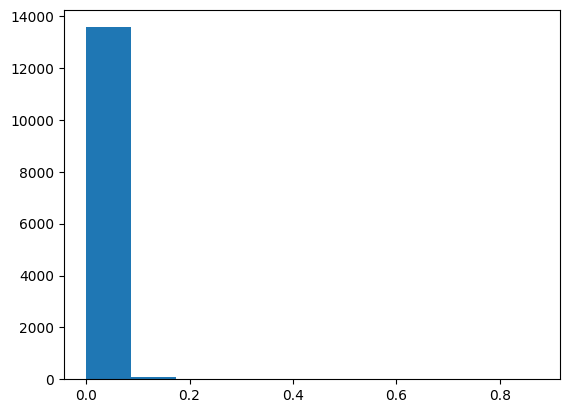

In [59]:
# #diff
# object threshold and cls_threshold are highly correlated! (for those above 0.1)
diff_list = [abs(i - j ) for i, j in zip(obj_thres, cls_thres) if i> 0.1 and j > 0.1]
plt.hist(diff_list)

In [60]:
cls_thresholds_list_new = [0.93, 0.95, 0.84, 0.8, 0.73, 0.75, 0.7, 0.82, 0.22, 0.69, 0.85, 0.68, 0.85, 0.85]
current_pred_all = copy.deepcopy(ap_calculator.pred_map_cls)
for i in range(len(ap_calculator.gt_map_cls)):
    current_pred_all[i] = [_i for _i in current_pred_all[i] if _i[-1] > cls_thresholds_list_new[_i[0]] and _i[-2] > cls_thresholds_list_new[_i[0]]]
rec_25, prec_25, ap_25 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.25)
rec_5, prec_5, ap_5 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.5)
rec_75, prec_75, ap_75 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.75)
rec_8, prec_8, ap_8 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.8)
rec_9, prec_9, ap_9 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.9)

In [61]:
def show_4_digit(_dict):
    temp_dict = _dict
    decimal_places = 4
    temp_dict = {key: round(value, decimal_places) for key, value in temp_dict.items()}
    print(temp_dict)

In [62]:
show_4_digit(ap_25)
show_4_digit(ap_5)
show_4_digit(ap_75)
show_4_digit(ap_8)
show_4_digit(ap_9)

{4: 0.9593, 8: 0.8046, 9: 0.9197, 0: 0.9787, 3: 0.9161, 10: 0.7486, 12: 0.9524, 13: 0.9621, 7: 0.9261, 1: 0.975, 5: 0.9075, 11: 0.9222, 6: 0.9274, 2: 0.8995}
{4: 0.9057, 8: 0.7059, 9: 0.8206, 0: 0.9594, 3: 0.8397, 10: 0.4282, 12: 0.8996, 13: 0.8298, 7: 0.8886, 1: 0.9714, 5: 0.7906, 11: 0.8469, 6: 0.8307, 2: 0.8484}
{4: 0.4436, 8: 0.1693, 9: 0.2417, 0: 0.6623, 3: 0.3228, 10: 0.0561, 12: 0.3918, 13: 0.1399, 7: 0.517, 1: 0.8425, 5: 0.1138, 11: 0.4135, 6: 0.2305, 2: 0.3991}
{4: 0.2223, 8: 0.0593, 9: 0.1014, 0: 0.3164, 3: 0.1541, 10: 0.019, 12: 0.1497, 13: 0.0493, 7: 0.292, 1: 0.6252, 5: 0.0208, 11: 0.238, 6: 0.0575, 2: 0.1784}
{4: 0.0028, 8: 0.0003, 9: 0.0009, 0: 0.0005, 3: 0.0022, 10: 0.0, 12: 0.0014, 13: 0.0014, 7: 0.0025, 1: 0.0203, 5: 0.0003, 11: 0.0029, 6: 0.0001, 2: 0.0009}


In [64]:
obj_thresholds_list_new = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
cls_thresholds_list_new = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
current_pred_all = copy.deepcopy(ap_calculator.pred_map_cls)
for i in range(len(ap_calculator.gt_map_cls)):
    current_pred_all[i] = [_i for _i in current_pred_all[i] if _i[-1] > cls_thresholds_list_new[_i[0]] and _i[-2] > obj_thresholds_list_new[_i[0]]]
rec_25, prec_25, ap_25 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.25)
rec_5, prec_5, ap_5 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.5)
rec_75, prec_75, ap_75 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.75)
rec_8, prec_8, ap_8 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.8)
rec_9, prec_9, ap_9 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.9)
show_4_digit(ap_25)
show_4_digit(ap_5)
show_4_digit(ap_75)
show_4_digit(ap_8)
show_4_digit(ap_9)

{4: 0.925, 9: 0.876, 8: 0.7178, 0: 0.9787, 3: 0.8728, 10: 0.7076, 12: 0.9524, 13: 0.9484, 7: 0.8852, 1: 0.9851, 11: 0.8824, 2: 0.8718, 5: 0.7462, 6: 0.8634}
{4: 0.8791, 9: 0.7889, 8: 0.6461, 0: 0.9594, 3: 0.8103, 10: 0.4187, 12: 0.8996, 13: 0.8249, 7: 0.8542, 1: 0.9815, 11: 0.8148, 2: 0.8352, 5: 0.6692, 6: 0.7779}
{4: 0.4377, 9: 0.2364, 8: 0.1628, 0: 0.6623, 3: 0.3172, 10: 0.0561, 12: 0.3918, 13: 0.1389, 7: 0.5079, 1: 0.8487, 11: 0.4066, 2: 0.3949, 5: 0.0957, 6: 0.2257}
{4: 0.2204, 9: 0.0999, 8: 0.0576, 0: 0.3164, 3: 0.1525, 10: 0.019, 12: 0.1497, 13: 0.0488, 7: 0.2874, 1: 0.6304, 11: 0.2354, 2: 0.1757, 5: 0.0187, 6: 0.0567}
{4: 0.0028, 9: 0.0009, 8: 0.0003, 0: 0.0005, 3: 0.0022, 10: 0.0, 12: 0.0014, 13: 0.0014, 7: 0.0025, 1: 0.0203, 11: 0.0029, 2: 0.0009, 5: 0.0003, 6: 0.0001}


In [65]:
obj_thresholds_list_new = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
cls_thresholds_list_new = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
current_pred_all = copy.deepcopy(ap_calculator.pred_map_cls)
for i in range(len(ap_calculator.gt_map_cls)):
    current_pred_all[i] = [_i for _i in current_pred_all[i] if _i[-1] > cls_thresholds_list_new[_i[0]] and _i[-2] > obj_thresholds_list_new[_i[0]]]
rec_25, prec_25, ap_25 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.25)
rec_5, prec_5, ap_5 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.5)
rec_75, prec_75, ap_75 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.75)
rec_8, prec_8, ap_8 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.8)
rec_9, prec_9, ap_9 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.9)

In [66]:
show_4_digit(ap_25)
show_4_digit(ap_5)
show_4_digit(ap_75)
show_4_digit(ap_8)
show_4_digit(ap_9)

{4: 0.8674, 9: 0.8045, 8: 0.6128, 0: 0.9787, 3: 0.794, 10: 0.5658, 12: 0.9524, 13: 0.9319, 7: 0.7702, 1: 0.975, 11: 0.807, 2: 0.7821, 6: 0.7669, 5: 0.5645}
{4: 0.8294, 9: 0.7321, 8: 0.5625, 0: 0.9594, 3: 0.7513, 10: 0.3694, 12: 0.8911, 13: 0.8149, 7: 0.7506, 1: 0.9714, 11: 0.7493, 2: 0.7651, 6: 0.7051, 5: 0.5174}
{4: 0.4258, 9: 0.2265, 8: 0.1541, 0: 0.6623, 3: 0.3061, 10: 0.0549, 12: 0.3918, 13: 0.1389, 7: 0.4694, 1: 0.8425, 11: 0.3849, 2: 0.3679, 6: 0.2191, 5: 0.0783}
{4: 0.2155, 9: 0.0974, 8: 0.0547, 0: 0.3164, 3: 0.1494, 10: 0.0186, 12: 0.1497, 13: 0.0488, 7: 0.27, 1: 0.6252, 11: 0.2247, 2: 0.1685, 6: 0.0542, 5: 0.0129}
{4: 0.0028, 9: 0.0008, 8: 0.0002, 0: 0.0005, 3: 0.0022, 10: 0.0, 12: 0.0014, 13: 0.0014, 7: 0.0025, 1: 0.0203, 11: 0.0029, 2: 0.0009, 6: 0.0001, 5: 0.0003}


In [96]:
# filter pred_all by threshold
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9]
threshold_dict = {}
for current_threshold in threshold_list:
    _key = str(current_threshold)
    threshold_dict[_key] = {}
    current_pred_all = copy.deepcopy(ap_calculator.pred_map_cls)
    for i in range(len(ap_calculator.gt_map_cls)):
            current_pred_all[i] = [_i for _i in current_pred_all[i] if _i[-1] > current_threshold]
    rec_25, prec_25, ap_25 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.25)
    threshold_dict[_key]['rec_25'] = rec_25
    threshold_dict[_key]['prec_25'] = prec_25
    threshold_dict[_key]['ap_25'] = ap_25
    rec_5, prec_5, ap_5 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.5)
    threshold_dict[_key]['rec_5'] = rec_5
    threshold_dict[_key]['prec_5'] = prec_5
    threshold_dict[_key]['ap_5'] = ap_5
    rec_75, prec_75, ap_75 = eval_det_multiprocessing(current_pred_all, ap_calculator.gt_map_cls, 0.75)
    threshold_dict[_key]['rec_75'] = rec_75
    threshold_dict[_key]['prec_75'] = prec_75
    threshold_dict[_key]['ap_75'] = ap_75
    print('25', threshold_dict[_key]['ap_25'], '5', threshold_dict[_key]['ap_5'], '75', threshold_dict[_key]['ap_75'])

25 {2: 0.9669344078162831, 4: 0.9736649493483792, 8: 0.8013889841110993, 0: 0.9977968379837538, 3: 0.9582510218598864, 7: 0.9536158441538727, 1: 0.9921923188401633, 5: 0.9544629618463694, 6: 0.9567427084093507} 5 {2: 0.8722270706907607, 4: 0.9238105553074238, 8: 0.7142420369325181, 0: 0.9882674698095258, 3: 0.884419058731724, 7: 0.9186577599610337, 1: 0.9887685129308397, 5: 0.8713655380109844, 6: 0.8547679176800966} 75 {2: 0.3823843994889877, 4: 0.4984389945028695, 8: 0.17918313601001096, 0: 0.7770403383703994, 3: 0.40609353723678804, 7: 0.6473285912028993, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461}
25 {4: 0.9722485175535187, 8: 0.7964436115810423, 0: 0.9977968379837538, 3: 0.9563168551752244, 7: 0.9536158441538727, 1: 0.9921923188401633, 5: 0.9544629618463694, 6: 0.9504027315943053, 2: 0.9669344078162831} 5 {4: 0.9224513213592584, 8: 0.712419792310374, 0: 0.9882674698095258, 3: 0.8832119830437546, 7: 0.9186577599610337, 1: 0.9887685129308397, 5: 0.871365538010

In [99]:
with open('data.pickle', 'wb') as file:
    pickle.dump(threshold_dict, file)

In [5]:
# for k, v in threshold_dict.items():
#     for _k, _v in v['ap_75'].items():
#         print(_k, f'{_v:.4f}')
    # for _k, _v in v.items():
        # print(k, _k)


In [6]:
with open('data.pickle', 'rb') as file:
    threshold_dict = pickle.load(file)
    

EOFError: Ran out of input

In [17]:
threshold_dict = {}
threshold_dict[0.1] = {25:{2: 0.9669344078162831, 4: 0.9736649493483792, 8: 0.8013889841110993, 0: 0.9977968379837538, 3: 0.9582510218598864, 7: 0.9536158441538727, 1: 0.9921923188401633, 5: 0.9544629618463694, 6: 0.9567427084093507}, 5: {2: 0.8722270706907607, 4: 0.9238105553074238, 8: 0.7142420369325181, 0: 0.9882674698095258, 3: 0.884419058731724, 7: 0.9186577599610337, 1: 0.9887685129308397, 5: 0.8713655380109844, 6: 0.8547679176800966}, 75: {2: 0.3823843994889877, 4: 0.4984389945028695, 8: 0.17918313601001096, 0: 0.7770403383703994, 3: 0.40609353723678804, 7: 0.6473285912028993, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461}}
threshold_dict[0.2] = {25: {4: 0.9722485175535187, 8: 0.7964436115810423, 0: 0.9977968379837538, 3: 0.9563168551752244, 7: 0.9536158441538727, 1: 0.9921923188401633, 5: 0.9544629618463694, 6: 0.9504027315943053, 2: 0.9669344078162831}, 5: {4: 0.9224513213592584, 8: 0.712419792310374, 0: 0.9882674698095258, 3: 0.8832119830437546, 7: 0.9186577599610337, 1: 0.9887685129308397, 5: 0.8713655380109844, 6: 0.8489069147133363, 2: 0.8722270706907607}, 75: {4: 0.4979884923017076, 8: 0.17918313601001096, 0: 0.7770403383703994, 3: 0.4057322256917965, 7: 0.6473285912028993, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.3823843994889877}}
threshold_dict[0.3] = {25: {4: 0.9715327731395645, 8: 0.7944353428032055, 0: 0.9977968379837538, 3: 0.9549829237506287, 7: 0.9519256182873803, 1: 0.9921923188401633, 5: 0.9544629618463694, 6: 0.9504027315943053, 2: 0.9636932615267073}, 5: {4: 0.921535157966383, 8: 0.711954351554793, 0: 0.9882674698095258, 3: 0.8819623584243363, 7: 0.917014484813055, 1: 0.9887685129308397, 5: 0.8713655380109844, 6: 0.8489069147133363, 2: 0.8692236918896095}, 75: {4: 0.4978365540117956, 8: 0.17897170212334806, 0: 0.7770403383703994, 3: 0.4057322256917965, 7: 0.6473285912028993, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.3823843994889877}}
threshold_dict[0.4] = {25: {4: 0.9688952545732363, 8: 0.7903327319055433, 0: 0.9977968379837538, 3: 0.9529197348995504, 7: 0.9519256182873803, 1: 0.9921923188401633, 5: 0.9453979404889892, 6: 0.9470180870496754, 2: 0.9636932615267073}, 5: {4: 0.9196942927272758, 8: 0.7091065781565833, 0: 0.9882674698095258, 3: 0.8800204521777952, 7: 0.917014484813055, 1: 0.9887685129308397, 5: 0.867141522823514, 6: 0.8457795031540982, 2: 0.8692236918896095}, 75: {4: 0.4973788729856004, 8: 0.17897170212334806, 0: 0.7770403383703994, 3: 0.40495313701529806, 7: 0.6473285912028993, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.3823843994889877}}
threshold_dict[0.5] = {25: {4: 0.967447393080773, 8: 0.786683511989878, 0: 0.9977968379837538, 3: 0.9472509272540597, 7: 0.9484713294380555, 1: 0.9921923188401633, 5: 0.9453979404889892, 6: 0.9401792125801002, 2: 0.9534952867923012}, 5: {4: 0.918534238495485, 8: 0.7071751543329061, 0: 0.9882674698095258, 3: 0.8773665530743481, 7: 0.9136563388517362, 1: 0.9887685129308397, 5: 0.867141522823514, 6: 0.8426209868328085, 2: 0.859782212901211}, 75: {4: 0.4972250661293336, 8: 0.17897170212334806, 0: 0.7770403383703994, 3: 0.4045543228697486, 7: 0.6460180831237199, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.3785609094662209}}
threshold_dict[0.6] = {25: {4: 0.9640524611069474, 8: 0.7803548956780876, 0: 0.9977968379837538, 3: 0.9407515218812936, 7: 0.9449968872670755, 1: 0.9921923188401633, 5: 0.9408278660137013, 6: 0.9401792125801002, 2: 0.9361902810250334}, 5: {4: 0.9166692460647872, 8: 0.7027749692669651, 0: 0.9882674698095258, 3: 0.8732980693324861, 7: 0.9102789865294652, 1: 0.9887685129308397, 5: 0.8628616118069747, 6: 0.8426209868328085, 2: 0.8468962648146452}, 75: {4: 0.497070781007595, 8: 0.1780799305408517, 0: 0.7770403383703994, 3: 0.4037332742525188, 7: 0.6446874971070964, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.37659005589231387}}
threshold_dict[0.65] = {25: {4: 0.9618582256876975, 8: 0.7734195514773636, 0: 0.9887059288928448, 3: 0.9363519736827534, 7: 0.9432510637736792, 1: 0.9921923188401633, 5: 0.9361489212650702, 6: 0.9401792125801002, 2: 0.925704583516435}, 5: {4: 0.9145576292023236, 8: 0.6968282763558176, 0: 0.9792615224858215, 3: 0.8705387468774286, 7: 0.9085821440559236, 1: 0.9887685129308397, 5: 0.8584813231061286, 6: 0.8426209868328085, 2: 0.8403992595711258}, 75: {4: 0.49675861953407496, 8: 0.1776274890716648, 0: 0.7693088175547664, 3: 0.4037332742525188, 7: 0.6446874971070964, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.37659005589231387}}
threshold_dict[0.7] = {25: {4: 0.9594123857637316, 8: 0.7642533231985924, 0: 0.9887059288928448, 3: 0.9304226826267402, 7: 0.9326177024755931, 1: 0.9921923188401633, 5: 0.9314490117446118, 6: 0.9401792125801002, 2: 0.9186953040249626}, 5: {4: 0.9126741461102269, 8: 0.6913108372624228, 0: 0.9792615224858215, 3: 0.8670479287590341, 7: 0.8999618835559811, 1: 0.9887685129308397, 5: 0.8540830120575711, 6: 0.8426209868328085, 2: 0.833872400125625}, 75: {4: 0.4964452193237152, 8: 0.17739486043579675, 0: 0.7693088175547664, 3: 0.4037332742525188, 7: 0.643326124270067, 1: 0.9100717290478253, 5: 0.282616387171082, 6: 0.3446683427184461, 2: 0.37659005589231387}}
threshold_dict[0.8] = {25: {4: 0.9459003556094869, 8: 0.7362914925151878, 0: 0.9887059288928448, 3: 0.9062040180726978, 7: 0.9058071398531423, 1: 0.9889035097706831, 5: 0.9028977841469737, 6: 0.9221396803240054, 2: 0.9186953040249626}, 5: {4: 0.9020211181427338, 8: 0.6702990284320407, 0: 0.9792615224858215, 3: 0.8498425190148411, 7: 0.8772945701753305, 1: 0.9854909284656921, 5: 0.8361805139667856, 6: 0.8259057831637246, 2: 0.833872400125625}, 75: {4: 0.4953343206386954, 8: 0.175223986675884, 0: 0.7693088175547664, 3: 0.39888661083288945, 7: 0.6404847253121633, 1: 0.9070186366693316, 5: 0.2803924206614012, 6: 0.34281203572982155, 2: 0.37659005589231387}}
threshold_dict[0.9] = {25: {4: 0.9092905913163429, 8: 0.6214396029277678, 0: 0.9332839826038677, 3: 0.8201723852287528, 7: 0.836661137671517, 1: 0.9822716907586135, 5: 0.8300680934412943, 2: 0.8394493055824981, 6: 0.8704383181043591}, 5: {4: 0.8709211048175609, 8: 0.5766218809781323, 0: 0.9332839826038677, 3: 0.7810073480992125, 7: 0.8114707327918675, 1: 0.978881860250139, 5: 0.7760805787407861, 2: 0.7733155901161988, 6: 0.7846388424665233}, 75: {4: 0.4873957925922072, 8: 0.16037766246882487, 0: 0.7377629808188383, 3: 0.38093039903989345, 7: 0.6185787810648509, 1: 0.9008645843841077, 5: 0.27816027780425834, 2: 0.3639912739892159, 6: 0.3349968106526741}}

In [22]:
decimal_places = 4
for k, v in threshold_dict.items():
    temp_dict = v[75]
    temp_dict = {key: round(value, decimal_places) for key, value in temp_dict.items()}
    print(temp_dict, sum(temp_dict.values())/ len(temp_dict))

{2: 0.3824, 4: 0.4984, 8: 0.1792, 0: 0.777, 3: 0.4061, 7: 0.6473, 1: 0.9101, 5: 0.2826, 6: 0.3447} 0.49197777777777774
{4: 0.498, 8: 0.1792, 0: 0.777, 3: 0.4057, 7: 0.6473, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3824} 0.4918888888888888
{4: 0.4978, 8: 0.179, 0: 0.777, 3: 0.4057, 7: 0.6473, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3824} 0.4918444444444444
{4: 0.4974, 8: 0.179, 0: 0.777, 3: 0.405, 7: 0.6473, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3824} 0.49172222222222217
{4: 0.4972, 8: 0.179, 0: 0.777, 3: 0.4046, 7: 0.646, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3786} 0.49108888888888885
{4: 0.4971, 8: 0.1781, 0: 0.777, 3: 0.4037, 7: 0.6447, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3766} 0.4905111111111111
{4: 0.4968, 8: 0.1776, 0: 0.7693, 3: 0.4037, 7: 0.6447, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3766} 0.4895666666666666
{4: 0.4964, 8: 0.1774, 0: 0.7693, 3: 0.4037, 7: 0.6433, 1: 0.9101, 5: 0.2826, 6: 0.3447, 2: 0.3766} 0.4893444444444444
{4: 0.4953, 8: 0.1752, 0: 0.7693, 3: 0.3989, 7: 0.6405, 1